In [1]:
import pywt
import numpy as np
from PIL import Image
import cv2
import os
from tqdm import tqdm
from concurrent import futures
import matplotlib.pyplot as plt

In [2]:
def wavelet_compression_rgb(image, wavelet='haar', level=2, threshold=0):
    """
    Compress an RGB image using wavelet transform by thresholding small coefficients.
    
    :param image: Input RGB image (PIL Image)
    :param wavelet: Type of wavelet to use ('haar', 'db1', 'coif1', etc.)
    :param level: Decomposition level
    :param threshold: Threshold ratio for compression
    :return: Compressed RGB image (PIL Image)
    """
    image_np = np.array(image)  # Convert PIL to NumPy
    compressed_channels = []

    for i in range(3):  # Loop over R, G, B channels
        channel = image_np[:, :, i]

        # Wavelet decomposition
        coeffs = pywt.wavedec2(channel, wavelet, level=level)

        # Apply thresholding (set small coefficients to zero)
        coeffs_thresholded = [coeffs[0]]  # Keep approximation coefficients
        for coeff in coeffs[1:]:
            cH, cV, cD = coeff
            cH[np.abs(cH) < threshold * np.max(cH)] = 0
            cV[np.abs(cV) < threshold * np.max(cV)] = 0
            cD[np.abs(cD) < threshold * np.max(cD)] = 0
            coeffs_thresholded.append((cH, cV, cD))

        # Reconstruct compressed channel
        compressed_channel = pywt.waverec2(coeffs_thresholded, wavelet)

        # Clip & convert back to uint8
        compressed_channels.append(np.clip(compressed_channel, 0, 255).astype(np.uint8))

    # Merge RGB channels & Convert back to PIL
    compressed_image_np = np.stack(compressed_channels, axis=-1)
    return Image.fromarray(compressed_image_np)

In [3]:
def wavelet_denoising_yuv(image, wavelet='haar', level=2, noise_sigma=0.05):
    """
    Denoise an RGB image using wavelet transform, applied only on the Y (luminance) channel.
    
    :param image: Input RGB image (PIL Image)
    :param wavelet: Type of wavelet to use
    :param level: Decomposition level
    :param noise_sigma: Noise level for thresholding
    :return: Denoised RGB image (PIL Image)
    """
    image_np = np.array(image)  # Convert PIL to NumPy
    image_yuv = cv2.cvtColor(image_np, cv2.COLOR_RGB2YUV)

    y, u, v = cv2.split(image_yuv)  # Extract channels

    def denoise_channel(channel):
        coeffs = pywt.wavedec2(channel, wavelet, level=level)
        sigma = noise_sigma * np.median(np.abs(coeffs[-1][-1])) / 0.6745
        sigma = max(sigma, 1e-3)  # Avoid zero or NaN issues
        threshold = sigma * np.sqrt(2 * np.log(channel.size))

        coeffs_thresholded = [coeffs[0]] + [
            tuple(pywt.threshold(c, threshold, mode='soft') for c in coeff) for coeff in coeffs[1:]
        ]

        channel_denoised = pywt.waverec2(coeffs_thresholded, wavelet)

        # Ensure shape consistency
        if channel_denoised.shape != channel.shape:
            channel_denoised = cv2.resize(channel_denoised, (channel.shape[1], channel.shape[0]))

        return np.clip(channel_denoised, 0, 255).astype(np.uint8)

    y_denoised = denoise_channel(y)

    # Merge back into YUV and convert to RGB properly
    image_denoised_yuv = cv2.merge((y_denoised, u, v))
    image_denoised_rgb = cv2.cvtColor(image_denoised_yuv, cv2.COLOR_YUV2RGB)

    return Image.fromarray(image_denoised_rgb)

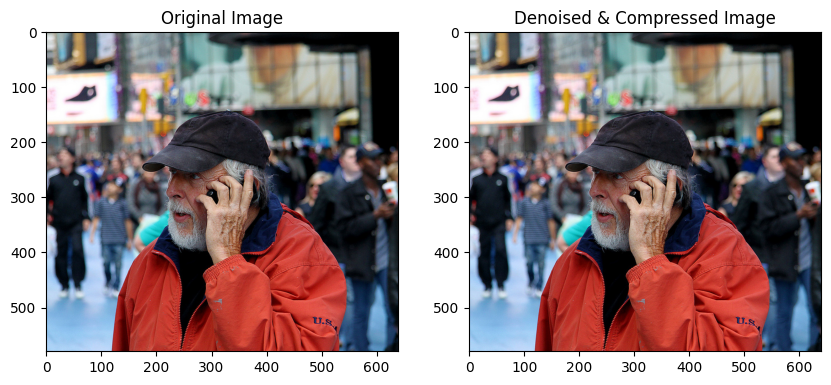

In [4]:
image_path = "train2017_20k\\000000000395.jpg"
image = Image.open(image_path).convert("RGB")
denoised_image = wavelet_denoising_yuv(image)

compressed_image = wavelet_compression_rgb(image)

# Plot using matplotlib both images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[1].imshow(compressed_image)
ax[1].set_title("Denoised & Compressed Image")
plt.show()

In [5]:
# Apply wavelet denoising and compression and save
def process_image(image_name):
    dataset_path = "train2017_20k"
    processed_path = "train2017_processed"
    error_img_list = []
    try:
        image_path = os.path.join(dataset_path, image_name)
        output_path = os.path.join(processed_path, image_name)
        image = Image.open(image_path).convert("RGB")
        # Apply wavelet denoising and compression sequentially
        denoised_image = wavelet_denoising_yuv(image)
        processed_image = wavelet_compression_rgb(denoised_image)
        processed_image.save(output_path)
    except Exception as e:
        error_img_list.append(image_name)
        print(f"Error processing {image_name}: {e}")
    return error_img_list

In [6]:
if __name__ == '__main__':
    dataset_path = "train2017_20k"
    processed_path = "train2017_processed"
    os.makedirs(processed_path, exist_ok=True)
    image_list = os.listdir(dataset_path)
    
    # Using ProcessPoolExecutor to process images concurrently
    with futures.ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        list(tqdm(executor.map(process_image, image_list), total=len(image_list)))

100%|██████████| 20000/20000 [05:50<00:00, 57.02it/s]
